<a href="https://colab.research.google.com/github/vasantvohra/PavBhaji-Not_PavBhaji/blob/master/PavBhaji_NotPavbhaji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing necessary functions


## Load Data Drive

In [0]:
# To get the input path.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        break
print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/pavbhaji/train/Not_PavBhaji/38860491_597428630651403_6027343862375120896_n.jpg


## Import Neccessary Packages

In [0]:
import random,os,glob
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Tensorflow Keras functions

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.random import set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D,Dense, Dropout,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.regularizers import l1, l2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#set_random_seed(0)
#np.random.seed(0)

## Hardware Config

In [0]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Generate Data


## Data Augmentation


In [0]:
path = "../input/pavbhaji"

In [0]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest')
validation_datagen = ImageDataGenerator(
        rescale = 1./255)
test_datagen = ImageDataGenerator(
        rescale = 1./255)

In [0]:
img_shape = (224, 224, 3) # default values

train_batch_size = 77 #64
val_batch_size = 33 #32

train_generator = train_datagen.flow_from_directory(
            directory = path + '/train', 
            target_size = (img_shape[0], img_shape[1]),
            batch_size = train_batch_size,
            class_mode = 'categorical',
            color_mode="rgb",
            shuffle = True,
            seed=42) #binary - not working

validation_generator = validation_datagen.flow_from_directory(
            directory = path + '/valid',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            color_mode="rgb",
            shuffle = True) #False

test_generator = test_datagen.flow_from_directory(
            directory = path + '/test',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = 1,
            class_mode = None,
            color_mode="rgb",
            shuffle = False)

Found 308 images belonging to 2 classes.
Found 132 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [0]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((77, 224, 224, 3), (77, 2))

In [0]:
print ("Train_generator",train_generator.class_indices)
print ("Validation_generator",validation_generator.class_indices)
print ("Test_generator",test_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)
labels = dict((v,k) for k,v in train_generator.class_indices.items())
print("Our Labels",labels)

Train_generator {'Not_PavBhaji': 0, 'PavBhaji': 1}
Validation_generator {'Not_PavBhaji': 0, 'PavBhaji': 1}
Test_generator {'Not_PavBhaji': 0, 'PavBhaji': 1}
Our Labels {0: 'Not_PavBhaji', 1: 'PavBhaji'}


## Visualize Data samples

In [0]:
def Visualize(image,label):
     fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
     for (img, classs, c_ax) in zip(image, label, m_axs.flatten()):
         img = np.squeeze(img)
         c_ax.imshow(img)
         c_ax.set_title('%s' % labels[np.argmax(classs)])
         c_ax.axis('off')

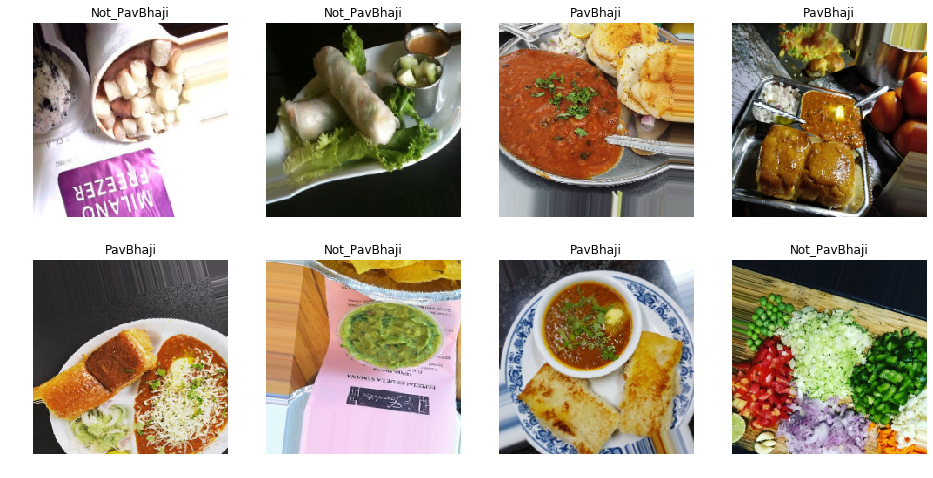

In [0]:
image,label = next(train_generator)
Visualize(image,label)

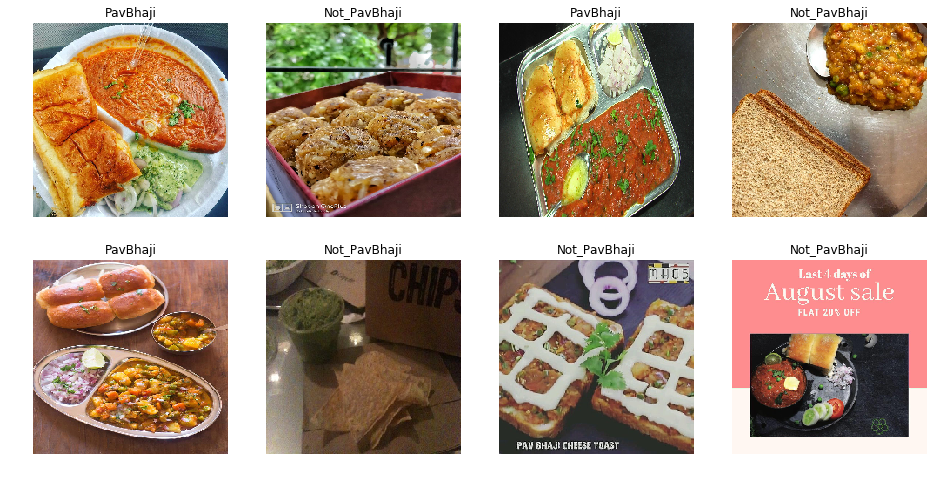

In [0]:
image,label = next(validation_generator)
Visualize(image,label)

In [0]:
#image,label = next(test_generator)
#Visualize(image,label)

## Pre trained model

In [0]:
from tensorflow.keras.applications import InceptionV3
#from tensorflow.keras.applications import VGG16
#from tensorflow.keras.applications import ResNet50
inception = InceptionV3(weights = 'imagenet',
              include_top = False,
              input_shape = img_shape)

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
print("Number of layers in the inception model: ", len(inception.layers))
# Freeze the layers except the last 30 layers
for layer in inception.layers[:-30]:
    layer.trainable = False

Number of layers in the inception model:  311


# Our model 


In [0]:
with strategy.scope():
    
# Create the model
    model = Sequential()

     # Add the convolutional base model
    model.add(inception)
    model.add(Conv2D(128, 3, activation='relu'))# kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    # Add new layers
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    # last layer
    model.add(Dense(2, activation='softmax', kernel_regularizer=l2(0.001))) #relu,sigmoid #not 1 -categorical

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 3, 3, 128)         2359424   
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 128)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2

### Train the model

In [0]:
model.compile(loss='categorical_crossentropy', #binary, Nadam acc doesn't change
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('inception.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) #Inception.h5

steps_per_epoch = train_generator.samples//train_generator.batch_size
validation_steps = validation_generator.samples//validation_generator.batch_size
start = time.time()
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch ,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1,
    workers=4,
    callbacks=[es, mc])
end = time.time()
print('Execution time: ', end-start)

Train for 4 steps, validate for 4 steps
Epoch 1/50
3/4 [=====================>........] - ETA: 10s - loss: 0.6997 - accuracy: 0.5022
Epoch 00001: val_accuracy improved from -inf to 0.58333, saving model to inception.h5
4/4 [==============================] - 49s 12s/step - loss: 0.6930 - accuracy: 0.5455 - val_loss: 0.6732 - val_accuracy: 0.5833
Epoch 2/50
3/4 [=====================>........] - ETA: 8s - loss: 0.6219 - accuracy: 0.7143 
Epoch 00002: val_accuracy did not improve from 0.58333
4/4 [==============================] - 42s 10s/step - loss: 0.6057 - accuracy: 0.7338 - val_loss: 1.2636 - val_accuracy: 0.5152
Epoch 3/50
3/4 [=====================>........] - ETA: 8s - loss: 0.5592 - accuracy: 0.7143 
Epoch 00003: val_accuracy did not improve from 0.58333
4/4 [==============================] - 41s 10s/step - loss: 0.5387 - accuracy: 0.7370 - val_loss: 1.2640 - val_accuracy: 0.5833
Epoch 4/50
3/4 [=====================>........] - ETA: 8s - loss: 0.4443 - accuracy: 0.7922 
Epoch 00

### Training history

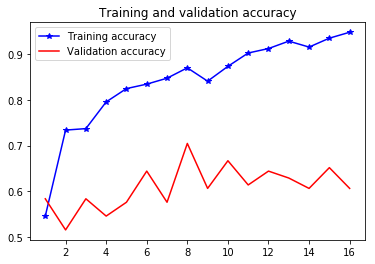

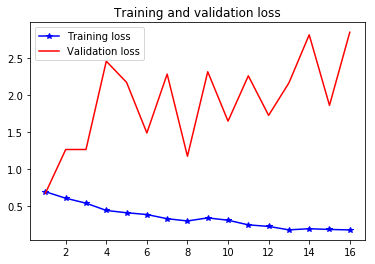

In [0]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
def load_img(img_path):
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0
    
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    return(img)

In [0]:
def prediction(img):
    
     model = tf.keras.models.load_model("inception.h5")
     p = model.predict(img[np.newaxis, ...])
     classes=[]
     prob=[]
     print("\n-------------------Individual Probability--------------------------------\n")
     for i,j in enumerate (p[0],0):
         print(labels[i].upper(),':',round(j*100,2),'%')
         classes.append(labels[i])
         prob.append(round(j*100,2))
         
     def plot_bar_x():
         # this is for plotting purpose
         index = np.arange(len(classes))
         plt.bar(index, prob)
         plt.xlabel('Labels', fontsize=12)
         plt.ylabel('Probability', fontsize=12)
         plt.xticks(index, classes, fontsize=12, rotation=20)
         plt.title('Probability for loaded image')
         plt.show()
     plot_bar_x()

Using TensorFlow backend.


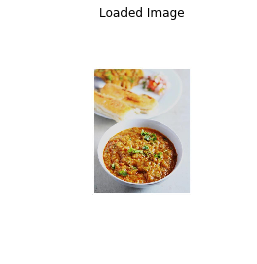

In [0]:
img = load_img(path +'/train/Not_PavBhaji/38618427_2227520140864849_2036571121217699840_n.jpg')


-------------------Individual Probability--------------------------------

NOT_PAVBHAJI : 87.4 %
PAVBHAJI : 12.6 %


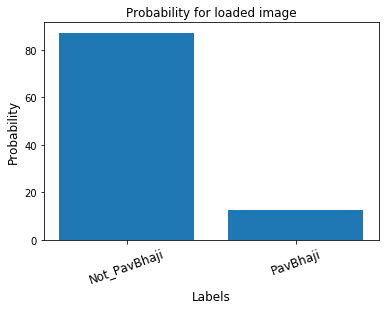

In [0]:
prediction(img)

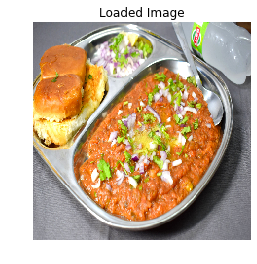

In [0]:
img = load_img(path +'/train/PavBhaji/20181115_125235.jpg')


-------------------Individual Probability--------------------------------

NOT_PAVBHAJI : 7.95 %
PAVBHAJI : 92.05 %


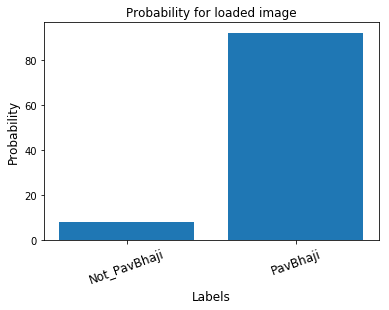

In [0]:
prediction(img)

### Prediction on Test Set

In [0]:
test_steps = test_generator.samples//test_generator.batch_size
test_generator.reset()
model = tf.keras.models.load_model("inception.h5")
prediction = model.predict_generator(test_generator,
                                steps = test_steps,
                                verbose=1)
#import pdb
#pdb.set_trace()
#print(prediction)
pred_binary = [np.argmax(value) for value in prediction] 
pred_binary = np.array(pred_binary)
#pred_binary.reshape(24,1)
#print(pred_binary)

import collections
print(collections.Counter(pred_binary))

##Id = test_generator.index_array
##Id = os.listdir("%s/test/PavBhaji"%path)
##Id.extend(os.listdir("%s/test/Not_PavBhaji"%path))
Id = test_generator.filenames
pred_list_new = [labels[f] for f in pred_binary]
##print(pred_list_new)
##print(len(Id))

test_df = pd.DataFrame({'Image_name': Id,'Predicted_Label': pred_list_new})
test_df.to_csv('submission.csv', header=True, index=False)
test_df

24/24 [==============================] - 4s 147ms/step
Counter({1: 20, 0: 4})


,Image_name,Predicted_Label
0,Not_PavBhaji/39687813_235963710399351_27232312...,PavBhaji
1,Not_PavBhaji/39744547_231289940899288_51330929...,PavBhaji
2,Not_PavBhaji/39756318_451914961975200_51140865...,PavBhaji
3,Not_PavBhaji/39763838_2013752995334492_6026328...,PavBhaji
4,Not_PavBhaji/39777006_248428879146731_62907057...,PavBhaji
5,Not_PavBhaji/39783547_2233089043587101_7833218...,Not_PavBhaji
6,Not_PavBhaji/39790065_708138802879611_43734992...,PavBhaji
7,Not_PavBhaji/39803333_1174189139400439_9829011...,Not_PavBhaji
8,Not_PavBhaji/39809477_925464760975925_83580973...,Not_PavBhaji
9,Not_PavBhaji/39881687_431084054067365_22776017...,PavBhaji


## Validation Evaluation

In [0]:
validation_steps = validation_generator.samples//validation_generator.batch_size
model.evaluate_generator(validation_generator,
                        steps = test_steps)

[0.1954426442583402, 0.70454544]

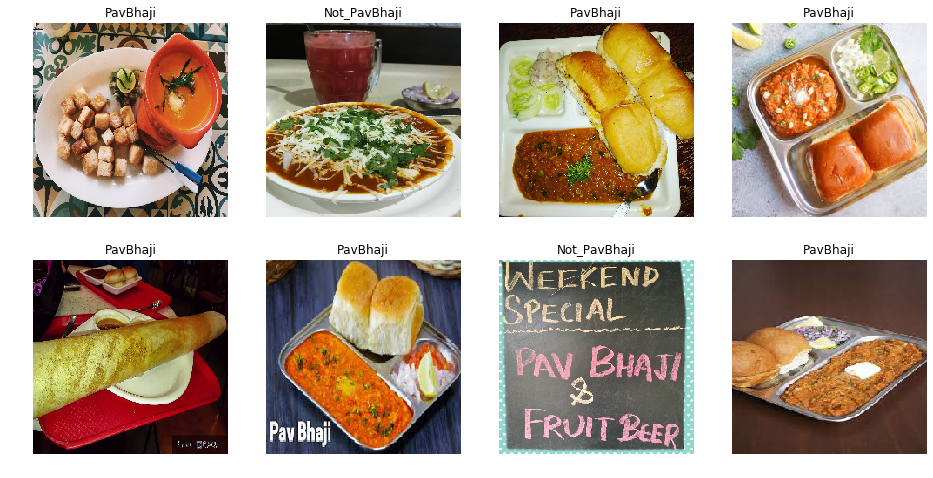

In [0]:
images, label = next(validation_generator)
model = tf.keras.models.load_model("inception.h5")
probabilities = model.predict(images)
Visualize(images,probabilities)

### Confusion Matrix & Sklearn classification report

              precision    recall  f1-score   support

Not_PavBhaji       0.89      0.42      0.57        19
    PavBhaji       0.54      0.93      0.68        14

    accuracy                           0.64        33
   macro avg       0.72      0.67      0.63        33
weighted avg       0.74      0.64      0.62        33



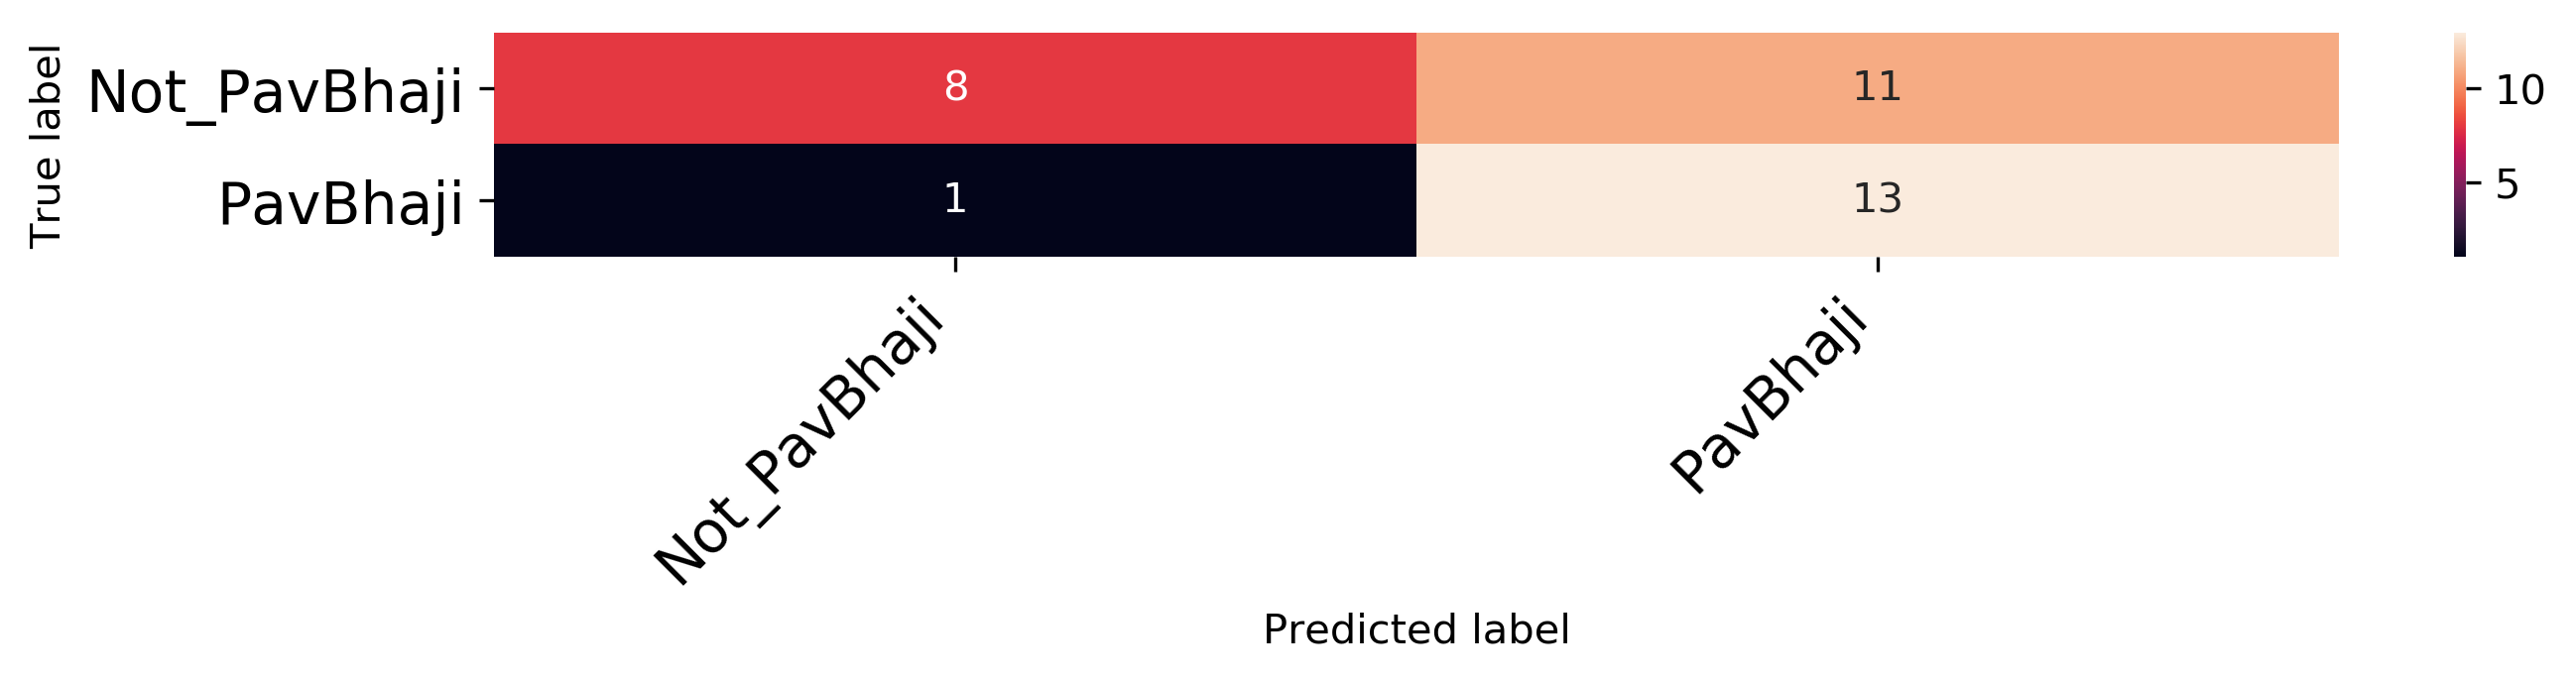

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
LABELS=['Not_PavBhaji','PavBhaji']
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize, dpi = 300)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

print_confusion_matrix(confusion_matrix(np.argmax(label,-1),np.argmax(probabilities,-1), labels = range(label.shape[1])), 
                            class_names = LABELS, figsize = (10, 1)).savefig('confusion_matrix.png')

print(classification_report(np.argmax(label,-1), 
                            np.argmax(probabilities,-1), 
                            target_names = LABELS))

## Saving File links

In [0]:
from IPython.display import FileLinks
FileLinks('.')

./
  submission.csv
  __notebook__.ipynb
  labels.txt
  inception.h5
  confusion_matrix.png